# Makes a Hovmuller of daily 3d variable (temp, salt) during Feb-April at a station location

### Uses the coordinates available in DMV_stations.txt, plots a hovmuller of temperature or salinity in the model to show the range of temperatures and salinity that can be found during that season

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client
import cmocean as cm
import datetime

In [8]:
# The package demonstrated here
import cf_xarray as cfxr

# For parallelization
import dask

# For loading shared data
import intake

# Visualizations
import matplotlib.pyplot as plt

# For basic data manipulation
import numpy as np
import xarray as xr

# For regridding
import xesmf as xe

# silence a minor warning
dask.config.set(**{"array.slicing.split_large_chunks": False})

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38395,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:41821,Total threads: 1
Dashboard: /proxy/33573/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44843,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')


## read file with station location

In [41]:
import pandas as pd
filename = "/home/581/ma3822/Denman2024Voyage/notebooks/DMV_stations.txt"
stations_array = pd.read_csv(filename, sep = "\t")
stations_array = stations_array.to_xarray()


### Select region and year (region covers all station location)

In [132]:
year = 2017
longitude_slice = slice(-270,-255)
latitude_slice = slice(-70,-58)
datetime_slice = slice(datetime.datetime(year,1,1), datetime.datetime(year+1,1,1))

### Inport bathymetry

In [128]:
ht = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='ht', session=master_session,
           frequency='static', n=1)
ht = ht.cf.sel( longitude = longitude_slice, latitude = latitude_slice)

### Choose variabile to plot and index of the station

In [191]:
variable_name = "temp" #can be any 3d variable available daily (salt, temp)
station_index = 50

Inport variable

In [192]:
var = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable=variable_name, 
           session=master_session, frequency='1 daily',
          attrs={'cell_methods': 'time: mean'},
          start_time="%s-01-01" %year, 
          end_time ="%s-01-01" %(year+1))


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [193]:
var = var.cf.sel(T=datetime_slice, Z=slice(0, 3000), longitude = longitude_slice, latitude = latitude_slice)

Select Feb to April

In [194]:
var_Feb_Apr = var.isel(time = slice(30, 120))

## Get station location in the model

In [199]:
station_coordinates = (float(stations_array.sel(index = station_index).Longitude), float(stations_array.sel(index = station_index).Latitude))
station_type = stations_array.StationType[station_index]

longitude_model = var_Feb_Apr.xt_ocean.to_numpy()
latitude_model = var_Feb_Apr.yt_ocean.to_numpy()
index_lon_station = np.abs(longitude_model%360 -station_coordinates[0]).argmin()
index_lat_station = np.abs(latitude_model -station_coordinates[1]).argmin()

## Get variable and depth (to only plot from the surface to depth)

In [196]:
depth_station =  float(ht.cf.isel(longitude = index_lon_station,latitude = index_lat_station))
var_station = var_Feb_Apr.cf.isel(longitude = index_lon_station,latitude = index_lat_station)
var_station = var_station.cf.sel(Z = slice(0,depth_station))
if variable_name == 'temp':
    var_station = var_station - 273.13

## Plot Hovmuller (var as a function of depth and time)

Text(0.5, 1.0, 'CTD: 95.305556, -64.767516')

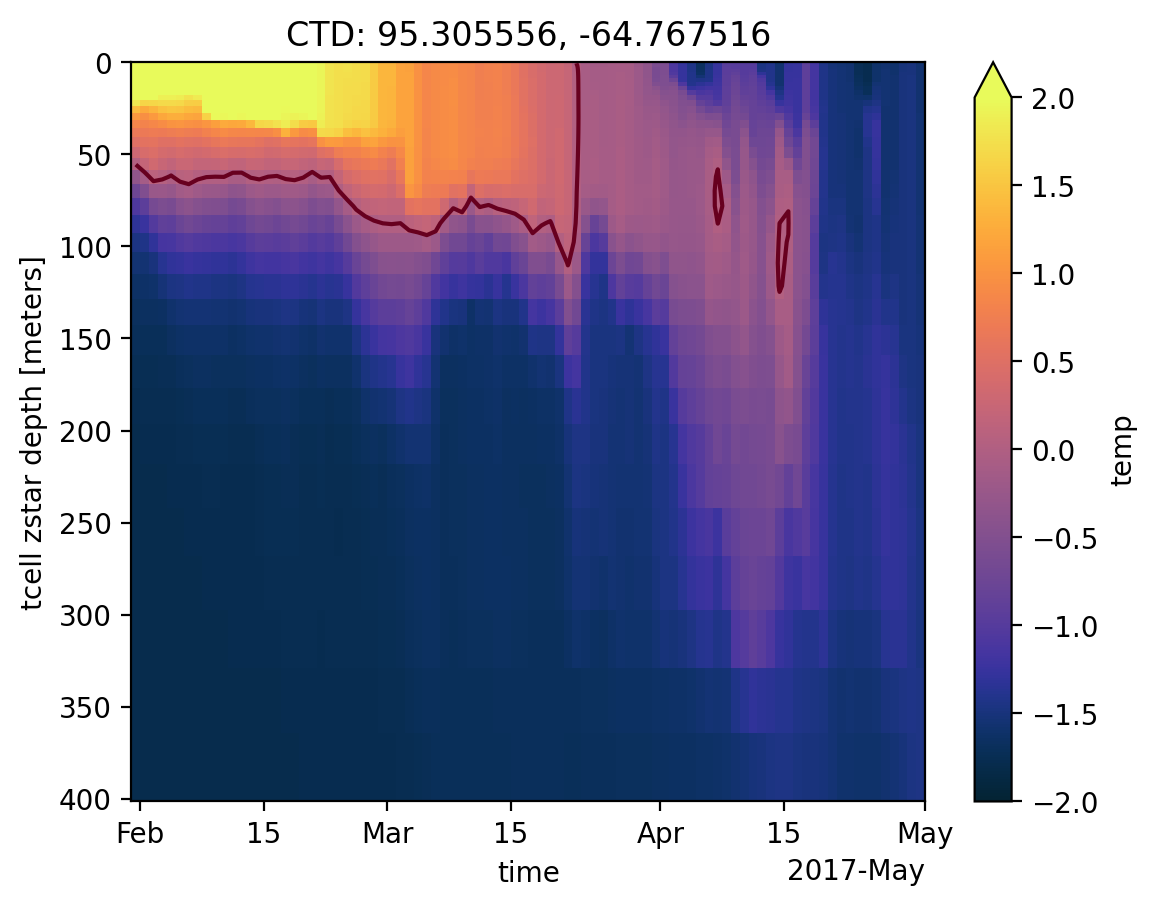

In [208]:
f,ax = plt.subplots(1,1)
if variable_name == 'salt':
     var_station.plot(x = 'time', y ='st_ocean', cmap = cm.cm.haline, ax = ax)
elif variable_name == 'temp':
    var_station.plot(x = 'time', y ='st_ocean', cmap = cm.cm.thermal, ax = ax, vmin = -2)
    var_station.plot.contour(x = 'time', y ='st_ocean', levels = [0], ax = ax, vmin = -2) ## Plot the 0 deg isotherm
else:
         var_station.plot(x = 'time', y ='st_ocean', ax = ax)
ax.invert_yaxis()
ax.set_title( "%s: %s, %s" %(station_type.to_numpy().tolist(),station_coordinates[0], station_coordinates[1]))